In [100]:
from t2_flujo import *
import folium
import matplotlib.pyplot as plt
import funciones
import parametros
import csv

In [101]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

# Mapa

In [102]:
north = -41.4
south = -41.496
east = -72.8
west = -73.03

PM = ox.graph_from_bbox(north,south,east,west,network_type='drive')

In [103]:
duplicados = []

for u,v,a in PM.edges(data = True):
  if len(PM[u][v]) == 2:
    duplicados.append((u,v,1))
  elif len(PM[u][v]) == 3:
    duplicados.append((u,v,1))
    duplicados.append((u,v,2))


duplicados = list(dict.fromkeys(duplicados))
PM.remove_edges_from(duplicados)

In [104]:
def setear(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Omitir el encabezado, si existe
        coordenadas = [tuple(map(float, row[1:3])) for row in reader]
    return coordenadas

In [105]:
coordenadas_plantas = setear('datos/ubicacion_produccion.csv')
coordenadas_almacenes = setear('datos/ubicacion_demanda.csv')
coordenadas_bodegas = setear('datos/ubicacion_bodegas_adicionales.csv')

print (coordenadas_plantas)
print(coordenadas_almacenes)
print(coordenadas_bodegas)

[(-72.9049847, -41.4382097), (-72.89773, -41.4616118), (-73.0018052, -41.4748112), (-72.9806647, -41.4723745), (-72.9569328, -41.4269752), (-72.886137, -41.4280949), (-72.9125495, -41.4548131)]
[(-72.9180463, -41.4723684), (-72.9469427, -41.4568804), (-72.9942386, -41.4478807), (-72.9723534, -41.4658041), (-72.9047511, -41.4556736), (-72.989895, -41.478831), (-72.9365376, -41.465138), (-72.9793107, -41.470842), (-72.9192027, -41.4598745), (-72.9708642, -41.4873284), (-72.9229513, -41.4737758), (-72.9237241, -41.4616888), (-72.9144487, -41.4744047), (-72.9690185, -41.4795911), (-72.9703678, -41.4669273), (-72.9420883, -41.4560195), (-72.9723474, -41.4671811), (-72.9100943, -41.4596985), (-72.9988203, -41.4658013), (-72.9911929, -41.4441747), (-72.9113151, -41.4222032), (-72.9172653, -41.4616971), (-72.9911983, -41.4790814), (-72.9037715, -41.4110034)]
[(-72.995677, -41.4626411), (-72.9575967, -41.4735434), (-72.9709703, -41.46606), (-72.9214348, -41.4473181), (-72.9017258, -41.4044988),

In [106]:
def buscar_nodo(grafo, lista_coords):
    nodos = []
    for ubicacion in lista_coords:
        x = ubicacion[0]
        y = ubicacion[1]
        nodo_cercano = ox.nearest_nodes(grafo, x, y)
        nodos.append(nodo_cercano)
    return nodos

In [107]:
n_plantas = buscar_nodo(PM, coordenadas_plantas)
n_almacenes = buscar_nodo(PM, coordenadas_almacenes)
n_bodegas = buscar_nodo(PM, coordenadas_bodegas)

print("Nodos plantas:", n_plantas)
print("Nodos almacenes:", n_almacenes)
print("Nodos bodegas:", n_bodegas)

Nodos plantas: [10827367167, 7564594729, 12119644005, 475560866, 1143298979, 3723703649, 1853718397]
Nodos almacenes: [9261244985, 265016378, 7832735376, 1886717431, 455782369, 476023196, 9569434781, 475560947, 6107982164, 475560777, 267183037, 266902436, 267182640, 476023935, 267456834, 262503262, 8856840317, 266105475, 1784870488, 1840721441, 3663848976, 266907565, 476023188, 1886787603]
Nodos bodegas: [1784870456, 267187616, 1886717444, 321004778, 1893185450, 9476649431, 265325294, 265742684, 9231325097, 3666343193, 4477723612, 3674253932, 4464073565, 7564594723, 1860972990, 3298590271, 476028433, 475563482]


In [108]:
plantas = []

for i in range(len(n_plantas)):
  plantas.append('planta' + str(i+1))


almacenes = []

for i in range(len(n_almacenes)):
  almacenes.append('almacén' + str(i+1))


bodegas = []

for i in range(len(n_bodegas)):
  bodegas.append('bodega' + str(i+1))



In [109]:
for node_id, nuevo_nombre in zip(n_plantas, plantas):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de planta no encontrado en el grafo")

for node_id, nuevo_nombre in zip(n_almacenes, almacenes):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de almacén no encontrado en el grafo")

for node_id, nuevo_nombre in zip(n_bodegas, bodegas):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de bodega no encontrado en el grafo")

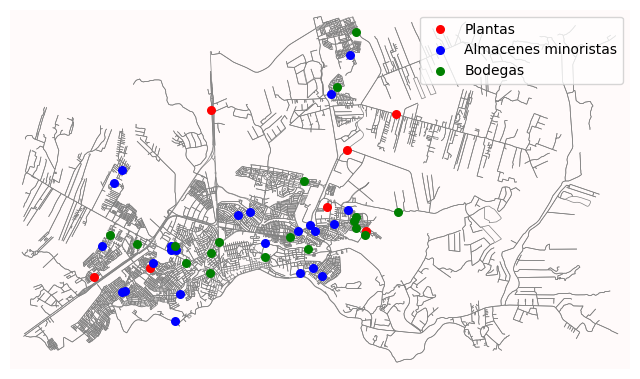

In [110]:
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(PM, node_size=0, edge_color="gray", edge_linewidth=0.5, bgcolor = 'snow', close=False, show=False)


ax.scatter([PM.nodes[node]['x'] for node in n_plantas],
           [PM.nodes[node]['y'] for node in n_plantas],
           c='red', s=30, label="Plantas")

ax.scatter([PM.nodes[node]['x'] for node in n_almacenes],
           [PM.nodes[node]['y'] for node in n_almacenes],
           c='blue', s=30, label="Almacenes minoristas")

ax.scatter([PM.nodes[node]['x'] for node in n_bodegas],
           [PM.nodes[node]['y'] for node in n_bodegas],
           c='green', s=30, label="Bodegas")

plt.legend(loc="upper right")
plt.show()

Definimos diccionarios con el nombr de cada nodo y las coordenadas que nos servirá más adelante para las funciones.

In [111]:
# Crear los diccionarios
map_plantas = {f'planta{i+1}': coord for i, coord in enumerate(coordenadas_plantas)}
map_almacenes = {f'almacen{i+1}': coord for i, coord in enumerate(coordenadas_almacenes)}
map_bodegas = {f'bodega{i+1}': coord for i, coord in enumerate(coordenadas_bodegas)}

# Output de ejemplo
print("map_plantas:", map_plantas)
print("map_almacenes:", map_almacenes)
print("map_bodegas:", map_bodegas)

map_plantas: {'planta1': (-72.9049847, -41.4382097), 'planta2': (-72.89773, -41.4616118), 'planta3': (-73.0018052, -41.4748112), 'planta4': (-72.9806647, -41.4723745), 'planta5': (-72.9569328, -41.4269752), 'planta6': (-72.886137, -41.4280949), 'planta7': (-72.9125495, -41.4548131)}
map_almacenes: {'almacen1': (-72.9180463, -41.4723684), 'almacen2': (-72.9469427, -41.4568804), 'almacen3': (-72.9942386, -41.4478807), 'almacen4': (-72.9723534, -41.4658041), 'almacen5': (-72.9047511, -41.4556736), 'almacen6': (-72.989895, -41.478831), 'almacen7': (-72.9365376, -41.465138), 'almacen8': (-72.9793107, -41.470842), 'almacen9': (-72.9192027, -41.4598745), 'almacen10': (-72.9708642, -41.4873284), 'almacen11': (-72.9229513, -41.4737758), 'almacen12': (-72.9237241, -41.4616888), 'almacen13': (-72.9144487, -41.4744047), 'almacen14': (-72.9690185, -41.4795911), 'almacen15': (-72.9703678, -41.4669273), 'almacen16': (-72.9420883, -41.4560195), 'almacen17': (-72.9723474, -41.4671811), 'almacen18': (-7

# Parte 0: Procesamiento

In [112]:
N = []
for a in range(len(nodos_totales)):
    lista = nodos_totales.loc[a].to_list()
    nodo = funciones.Node(lista[0], lista[1], lista[2], lista[3], lista[4])
    N.append(nodo)

# DICCIONARIO DE ID EN EL MAPA Y EL ID QUE LE PUSE A LOS NODOS

ids = nodos_totales['id_nodo'].to_list()
nombres = nodos_totales['id'].to_list()

dict_ids_nombres = {}

for a in range(len(ids)):
    dict_ids_nombres[ids[a]] = nombres[a]

for a in range(1,parametros.P+1):
    nombres.append(f'PB{a}')

In [113]:
# Como se especifica que el transporte es desde los nodos de produccion a bodegas y demanda, y de los nodos
# de bodega  a los nodos de demanda, elimino los arcos que no sirven para del grafo de todos los nodos conectados entre si.

# list(grafo_vial.edges(data=True))[par][origen/destino]
grafo_vial_nuevo = grafo_vial.copy()
lista_pares_nodos = list(grafo_vial_nuevo.edges())

for b in range(len(lista_pares_nodos)):
    a = lista_pares_nodos[b]
    
    O = nodos_totales[nodos_totales['id_nodo'] == a[0]]
    O_pos = O.index[0]

    D = nodos_totales[nodos_totales['id_nodo'] == a[1]]
    D_pos = D.index[0]

    if O['tipo'][O_pos] == D['tipo'][D_pos]:
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos],D['id_nodo'][D_pos])
    
    elif O['tipo'][O_pos] == 'demanda':
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos], D['id_nodo'][D_pos])

info_tipo_nodo = list(dict(grafo_vial_nuevo.nodes(data=True)).values())

In [114]:
# Las rutas minimas entre los nodos (todo el grafo se demora 1 min aprox)
r_min = funciones.rutas_min(grafo_vial_nuevo, parametros.G, len(list(grafo_vial_nuevo.edges())))
#graficar_rutas_min_n(r_min[0], G, 100)

In [115]:
# matriz de costos con las distancias entre los nodos en el mapa
matriz_costos = []
lista_arcos = list(grafo_vial_nuevo.edges(data=True))

for a in range(len(r_min[0])):
    matriz_costos.append([dict_ids_nombres[lista_arcos[a][0]],
                         dict_ids_nombres[lista_arcos[a][1]],
                         r_min[1][a],
                         r_min[0][a]])

In [116]:
matriz_costos_prod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_prod_bod = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_bod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])

for a in matriz_costos:
    if 'P' in a[0]:
        if 'D' in a[1]:
            matriz_costos_prod_dem = matriz_costos_prod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
        elif 'B' in a[1]:
            matriz_costos_prod_bod = matriz_costos_prod_bod._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
    if 'B' in a[0]:
        matriz_costos_bod_dem = matriz_costos_bod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)

In [117]:
I = parametros.P
J = parametros.B + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_bodegas.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_bodega = pd.DataFrame(data = dict_matriz)


prod_bodega['id'] = list(nodos_produccion.index)

prod_bodega = prod_bodega.set_index('id')

for i in range(len(matriz_costos_prod_bod)):
    fila = matriz_costos_prod_bod.loc[i]['origen']
    columna = matriz_costos_prod_bod.loc[i]['destino']
    guardar = matriz_costos_prod_bod.loc[i]['distancia']
    prod_bodega.loc[fila][columna] = guardar

In [118]:
I = parametros.P
J = parametros.D + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_demanda = pd.DataFrame(data = dict_matriz)


prod_demanda['id'] = list(nodos_produccion.index)

prod_demanda = prod_demanda.set_index('id')

for i in range(len(matriz_costos_prod_dem)):
    fila = matriz_costos_prod_dem.loc[i]['origen']
    columna = matriz_costos_prod_dem.loc[i]['destino']
    guardar = matriz_costos_prod_dem.loc[i]['distancia']
    prod_demanda.loc[fila][columna] = guardar


In [119]:
I = parametros.B
J = parametros.D + 1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

bod_demanda = pd.DataFrame(data = dict_matriz)


bod_demanda['id'] = list(nodos_bodegas.index)

bod_demanda = bod_demanda.set_index('id')

for i in range(len(matriz_costos_bod_dem)):
    fila = matriz_costos_bod_dem.loc[i]['origen']
    columna = matriz_costos_bod_dem.loc[i]['destino']
    guardar = matriz_costos_bod_dem.loc[i]['distancia']
    bod_demanda.loc[fila][columna] = guardar

In [120]:
prod_demanda_distancias = prod_demanda
prod_demanda = round((prod_demanda / 1000) * 12)

prod_bodega_distancias = prod_bodega
prod_bodega = round((prod_bodega / 1000) * 12)

bod_demanda_distancias = bod_demanda
bod_demanda = round((bod_demanda / 1000) * 12)

# Parte I

## Construcción del grafo

In [121]:
G1 = nx.DiGraph()

### Nodos

In [122]:
#se agregan los nodos correspondientes a las tiendas

entra = 0
sale = 0

for d in range(1, parametros.D+1):
  for t in range(1, parametros.T+1):
    nombre_nodo = 'D' + str(d) + ', t' + str(t)
    demanda = (demanda_max.loc[f'D{d}'][f'{t}'] - demanda_min.loc[f'D{d}'][f'{t}'])
    sale += demanda
    G1.add_node(nombre_nodo, demand = demanda)

In [123]:
#se agregan los nodos correspondientes a las fábricas

for p in range(1, parametros.P+1):
  for t in range(1, parametros.T):
    nombre_nodo = 'P' + str(p) + ', t' + str(t)
    oferta = (oferta_max_proveedores.loc[f'P{p}'][f'{t}'] - oferta_min_proveedores.loc[f'P{p}'][f'{t}'])
    entra += oferta
    G1.add_node(nombre_nodo, demand = -oferta)

In [124]:
inv_inicial_fabricas = inventario_inicial.to_dict()['1']
inv_inicial_bodegas = inventario_inicial_adicional.to_dict()['1']

In [125]:
#se agregan los nodos correspondientes a las bodegas de las fábricas

inv_0_fabricas = 0

for i in range(1, parametros.P + 1):
  for j in range(1, parametros.T + 1):
    nombre_nodo = 'P_bodega' + str(i) + ', t' + str(j)
    if j == 1:
      oferta = inv_inicial_fabricas[f'P{i}']
      inv_0_fabricas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [126]:
#se agregan los nodos de bodegas adicionales
inv_0_bodegas = 0

for i in range(1, 5):
  for j in range(1, parametros.T+1):
    nombre_nodo = 'B' + str(i) + ', t' + str(j)
    if j == 1:
      oferta = inv_inicial_bodegas[f'B{i}']
      inv_0_bodegas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [127]:
#se agregan nodos auxiliares para todas las bodegas, tanto de fábricas como bodegas adicionales

for p in range(1, parametros.P + 1):
  for j in range(1, parametros.T +1):
    nombre_nodo = 'P_aux' + str(i) + ', t' + str(j)
    G1.add_node(nombre_nodo)

for i in range(1, 5):
  for j in range(1, parametros.T+1):
    nombre_nodo = 'B_aux' + str(i) + ', t' + str(j)
    G1.add_node(nombre_nodo)

In [128]:
# vemos cuanto falta para balancear la demanda
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

-23354


In [129]:
G1.add_node('Sumidero', demand = -suma)

In [130]:
# verificamos que la demanda esta balanceada
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

0


### Arcos

In [131]:
#se añaden los arcos desde cada fábrica a su nodo auxiliar en todos los periodos

for t in range(1, parametros.T):
  for i in range(1, parametros.P + 1):
      nombrefab = 'P' + str(i) + ', t' + str(t)
      nombreaux = 'P_aux' + str(i) + ', t' + str(t)
      costo_prod = costo_produccion.loc[f'P{i}'][f'{t}']
      G1.add_edge(nombrefab, nombreaux, weight = costo_prod)


In [132]:
#se agregan los arcos desde cada bodega de fábrica hasta cada tienda en todos los periodos

for t in range(1, parametros.T + 1):
  for b in range(1, parametros.P + 1):
    for s in range(1, parametros.D+1):
      costo_trans = prod_demanda.loc[f'P{b}'][f'D{s}']
      p_venta = precio_venta[f'{t}'][f'D{s}']

      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombretienda = 'D' + str(s) + ', t' + str(t)
      G1.add_edge(nombrebod, nombretienda, weight = costo_trans-p_venta)

In [133]:
#agregamos el arco que une cada bodega de fábrica con el nodo auxiliar de esa fábrica del mismo periodo

for t in range(1, parametros.T+1):
  for b in range(1, parametros.P+1):
    nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
    nombreaux = 'P_aux' + str(b) + ', t' + str(t)
    G1.add_edge(nombrebod, nombreaux, weight = 0)

In [134]:
#agregamos los arcos que unen el nodo auxiliar de la bodega de una fábrica con el nodo de la misma bodega pero
#en el periodo siguiente

for t in range(1, parametros.T):
  for b in range(1, parametros.P + 1):
    nombreaux = 'P_aux' + str(b) + ', t' + str(t)
    nombrebod = 'P_bodega' + str(b) + ', t' + str(t + 1)
    c_almacenaje = costo_almacenaje.loc[f'P{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje.loc[f'P{b}'][f'{t}']
    G1.add_edge(nombreaux, nombrebod, weight = c_almacenaje, capacity = capacidad_max)

In [135]:
#agregamos arcos desde bodegas de fabricas hasta auxiliares de bodegas adicionales del mismo periodo

for t in range(1, parametros.T+1):
  for b in range(1, parametros.P +1):
    for a in range(1, 5):
      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
      costo_trans = prod_bodega.loc[f'P{b}'][f'B{a}']
      G1.add_edge(nombrebod, nombreauxad, weight = costo_trans)

In [136]:
#agregamos arcos  desde nodos auxiliares de bodegas adicionales hasta la misma bodega en el siguiente periodo, para
#todos los periodos y todas las bodegas

for t in range(1, parametros.T):
  for a in range(1, 5):
    nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
    nombrebodad = 'B' + str(a) + ', t' + str(t + 1)
    c_almacenaje = costo_almacenaje_adicional.loc[f'B{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje_adicional.loc[f'B{b}'][f'{t}']
    G1.add_edge(nombreauxad, nombrebodad, weight = c_almacenaje, capacity = capacidad_max)

In [137]:
#agregamos el arco que une cada bodega adicional con el nodo auxiliar de esa bodega adicional del mismo periodo

for t in range(1, parametros.T+1):
  for a in range(1, 5):
    nombrebodad = 'B' + str(a) + ', t' + str(t)
    nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
    G1.add_edge(nombrebodad, nombreauxad, weight = 0)

In [138]:
#agregamos arcos que unen las bodegas adicionales con las tiendas para todos los periodos

for t in range(1, parametros.T +1):
  for s in range(1, parametros.D+1):
    for a in range(1, 5):
      nombrebodad = 'B' + str(a) + ', t' + str(t)
      nombretienda = 'D' + str(s) + ', t' + str(t)

      costo_trans = bod_demanda.loc[f'B{a}'][f'D{s}']
      p_venta = precio_venta[f'{t}'][f'D{s}']

      G1.add_edge(nombrebodad, nombretienda, weight = costo_trans-p_venta)

In [139]:
#agregamos arcos desde fábricas hasta el sumidero para absorber el exceso de oferta

for t in range(1, parametros.T):
  for f in range(1, parametros.P + 1):
    nombrefab = 'P' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 10000000000000000000)

In [140]:
#agregamos arcos desde el sumidero hasta las tiendas en caso de que no se cumpla la demanda

for t in range(1, parametros.T+1):
  for s in range(1, parametros.D+1):
    nombretienda = 'D' + str(s) + ', t' + str(t)
    G1.add_edge('Sumidero', nombretienda, weight = 0)

### Solución al problema

In [141]:
sol = nx.min_cost_flow(G1, demand='demand', capacity='capacity', weight='weight')

In [142]:
# Obtener el tipo de la variable
tipo = type(sol)
print(tipo)
sol

<class 'dict'>


{'D1, t1': {},
 'D1, t2': {},
 'D1, t3': {},
 'D1, t4': {},
 'D1, t5': {},
 'D1, t6': {},
 'D1, t7': {},
 'D1, t8': {},
 'D2, t1': {},
 'D2, t2': {},
 'D2, t3': {},
 'D2, t4': {},
 'D2, t5': {},
 'D2, t6': {},
 'D2, t7': {},
 'D2, t8': {},
 'D3, t1': {},
 'D3, t2': {},
 'D3, t3': {},
 'D3, t4': {},
 'D3, t5': {},
 'D3, t6': {},
 'D3, t7': {},
 'D3, t8': {},
 'D4, t1': {},
 'D4, t2': {},
 'D4, t3': {},
 'D4, t4': {},
 'D4, t5': {},
 'D4, t6': {},
 'D4, t7': {},
 'D4, t8': {},
 'D5, t1': {},
 'D5, t2': {},
 'D5, t3': {},
 'D5, t4': {},
 'D5, t5': {},
 'D5, t6': {},
 'D5, t7': {},
 'D5, t8': {},
 'D6, t1': {},
 'D6, t2': {},
 'D6, t3': {},
 'D6, t4': {},
 'D6, t5': {},
 'D6, t6': {},
 'D6, t7': {},
 'D6, t8': {},
 'D7, t1': {},
 'D7, t2': {},
 'D7, t3': {},
 'D7, t4': {},
 'D7, t5': {},
 'D7, t6': {},
 'D7, t7': {},
 'D7, t8': {},
 'D8, t1': {},
 'D8, t2': {},
 'D8, t3': {},
 'D8, t4': {},
 'D8, t5': {},
 'D8, t6': {},
 'D8, t7': {},
 'D8, t8': {},
 'D9, t1': {},
 'D9, t2': {},
 'D9, t3':

## Construcción de funciones

In [143]:
# Lista con todos los nodos (nombre) y los periodos de tiempo en formato 't...'
bodegas = list(nodos_bodegas.index)
fabricas = list(nodos_produccion.index)
tiendas = list(nodos_demanda.index)

dias = []
for t in range(1, parametros.T+1):
  dias.append('t' + str(t))

fabricas_bodegas = []
fabricas_aux = []
for i in range(1, parametros.P + 1):
  fabricas_bodegas.append('P_bodega' + str(i))
  fabricas_aux.append('P_aux' + str(i))

bodegas_aux = []
for i in range(1, 5):
  fabricas_bodegas.append('B_aux' + str(i))

#### Funcion 1

Construcción de una función que reciba como argumentos un periodo de tiempo, y que 
entregue un gráfico que muestre las plantas, bodegas y minoristas, y que ilustre las rutas 
y cargas transportadas entre estos nodos.

Primero, se requiere crear un diccionario que lea los flujos para cada periodo.

In [182]:
flujos_totales = {}

for t in range(1, 9): #itera para cada periodo 1 a 8
    flujos_periodo = {}
    for nodo_origen, subflujos in sol.items():
        #verificar que el nodo esté en el periodo deseado
        if f', t{t}' in nodo_origen:
            #extraer el tipo de nodo y el índice de origen (Todos los P serán planta, todos los B serán bodega y todos los D serán almacén)
            if nodo_origen.startswith("P_aux"):
                tipo_origen = "planta"
                indice_origen = nodo_origen.split("P_aux")[-1].split(',')[0]
            elif nodo_origen.startswith("P_bodega"):
                tipo_origen = "planta"
                indice_origen = nodo_origen.split("P_bodega")[-1].split(',')[0]
            elif nodo_origen.startswith("P"):
                tipo_origen = "planta"
                indice_origen = nodo_origen.split("P")[-1].split(',')[0]
            elif nodo_origen.startswith("B_aux"):
                tipo_origen = "bodega"
                indice_origen = nodo_origen.split("B")[-1].split(',')[0]
            elif nodo_origen.startswith("B"):
                tipo_origen = "bodega"
                indice_origen = nodo_origen.split("B")[-1].split(',')[0]
            elif nodo_origen.startswith("D"):
                tipo_origen = "almacen"
                indice_origen = nodo_origen.split("D")[-1].split(',')[0]
            else:
                continue  # si el nodo no coincide con ningún formato (Sumidero), omitirlo
            
            origen = f"{tipo_origen}{indice_origen}"
            
            for nodo_destino, flujo in subflujos.items():
                if flujo != 0:
                    #lo mismo pero ahora con destinos
                    if nodo_destino.startswith("P_aux"):
                        tipo_destino = "planta"
                        indice_destino = nodo_destino.split("P_aux")[-1].split(',')[0]
                    elif nodo_destino.startswith("P_bodega"):
                        tipo_destino = "planta"
                        indice_destino = nodo_destino.split("P_bodega")[-1].split(',')[0]
                    elif nodo_destino.startswith("P"):
                        tipo_destino = "planta"
                        indice_destino = nodo_destino.split("P")[-1].split(',')[0]
                    elif nodo_destino.startswith("B_aux"):
                        tipo_destino = "bodega"
                        indice_destino = nodo_destino.split("B_aux")[-1].split(',')[0]
                    elif nodo_destino.startswith("B"):
                        tipo_destino = "bodega"
                        indice_destino = nodo_destino.split("B")[-1].split(',')[0]
                    elif nodo_destino.startswith("D"):
                        tipo_destino = "almacen"
                        indice_destino = nodo_destino.split("D")[-1].split(',')[0]
                    else:
                        continue
                    
                    destino = f"{tipo_destino}{indice_destino}"
                    
                    #arco:(o,d) y su flujo
                    arco = (origen, destino)
                    flujos_periodo[arco] = flujo
    flujos_totales[t] = flujos_periodo


In [177]:
def mapa_flujo(G, periodo):
    # Verificar si el periodo tiene datos de flujo
    if periodo not in flujos_totales:
        print(f"Periodo {periodo} no es válido para el periodo productivo")
        return

    flujos_para_periodo = flujos_totales[periodo]

    fig, ax = ox.plot_graph(G, node_size=0, edge_color="gray", edge_linewidth=0.5, bgcolor='white', close=False, show=False)

    #graficamos y asignamos leyenda:

    #plantas
    ax.scatter([], [], c='red', s=50, label='Planta')  # Entrada vacía para la leyenda de plantas
    for coord in map_plantas.values():
        ax.scatter(coord[0], coord[1], c='red', s=50)

    #almacenes
    ax.scatter([], [], c='blue', s=50, label='Almacén')  # Entrada vacía para la leyenda de almacenes
    for coord in map_almacenes.values():
        ax.scatter(coord[0], coord[1], c='blue', s=50)

    #bodegas
    primeras_cuatro_bodegas = list(map_bodegas.items())[:4]
    ax.scatter([], [], c='green', s=50, label='Bodega')
    for _, coord in primeras_cuatro_bodegas:
        ax.scatter(coord[0], coord[1], c='green', s=50)

    #leyenda para las lineas de la ruta
    ax.plot([], [], linewidth=1.5, color='green', label='Flujo ≤ 100')
    ax.plot([], [], linewidth=1.5, color='yellow', label='101 ≤ Flujo ≤ 300')
    ax.plot([], [], linewidth=2, color='orange', label='301 ≤ Flujo ≤ 500')
    ax.plot([], [], linewidth=2.5, color='red', label='Flujo > 500') 

    #graficar rutas y cantidades de flujo:
    for (nodo_fuente, nodo_objetivo), cantidad_de_flujo in flujos_para_periodo.items():
        coords_fuente = None
        coords_objetivo = None

        #verificar en que diccionario map_x se encuentra el nodo
        if nodo_fuente in map_plantas:
            coords_fuente = map_plantas[nodo_fuente]
        elif nodo_fuente in map_almacenes:
            coords_fuente = map_almacenes[nodo_fuente]
        elif nodo_fuente in map_bodegas and nodo_fuente in dict(primeras_cuatro_bodegas):
            coords_fuente = map_bodegas[nodo_fuente]

        if nodo_objetivo in map_plantas:
            coords_objetivo = map_plantas[nodo_objetivo]
        elif nodo_objetivo in map_almacenes:
            coords_objetivo = map_almacenes[nodo_objetivo]
        elif nodo_objetivo in map_bodegas and nodo_objetivo in dict(primeras_cuatro_bodegas):
            coords_objetivo = map_bodegas[nodo_objetivo]

        #verificar si ambos nodos están en el grafo y obtener el camino más corto
        if coords_fuente and coords_objetivo:
            try:
                #busca el nodo mas cercano en G dadas las coordenadas
                nodo_grafo_fuente = ox.distance.nearest_nodes(G, coords_fuente[0], coords_fuente[1])
                nodo_grafo_objetivo = ox.distance.nearest_nodes(G, coords_objetivo[0], coords_objetivo[1])

                #ruta minima
                ruta_min = nx.shortest_path(G, source=nodo_grafo_fuente, target=nodo_grafo_objetivo, weight='length')
                
                #extrae las coordenadas de la ruta minima
                coordenadas_del_camino = [(G.nodes[nodo]['x'], G.nodes[nodo]['y']) for nodo in ruta_min]

                #grafica la ruta con el color y ancho de línea que asignamos
                x, y = zip(*coordenadas_del_camino)
                if cantidad_de_flujo <= 100:
                    ancho_de_linea = 1
                    color = 'green'
                elif cantidad_de_flujo <= 300:
                    ancho_de_linea = 1.5
                    color = 'yellow'
                elif cantidad_de_flujo <= 500:
                    ancho_de_linea = 2
                    color = 'orange'
                else:
                    ancho_de_linea = 2.5
                    color = 'red'


            except nx.NetworkXNoPath:
                print(f"No hay un camino entre {nodo_fuente} y {nodo_objetivo} en el grafo.")
        else:
            print(f"Flujo no graficado: Nodo {nodo_fuente} o {nodo_objetivo} corresponden al mismo nodo geográficamente")

    plt.title(f"Rutas y flujo para el período {periodo}")
    plt.axis('off')
    #leyenda y eliminación de duplicados (ayuda de chatGpt)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")
    plt.show()

Flujo no graficado: Nodo bodega_aux1 o bodega1 corresponde(n) al mismo nodo geográficamente
Flujo no graficado: Nodo bodega_aux3 o bodega3 corresponde(n) al mismo nodo geográficamente
Flujo no graficado: Nodo bodega_aux4 o bodega4 corresponde(n) al mismo nodo geográficamente


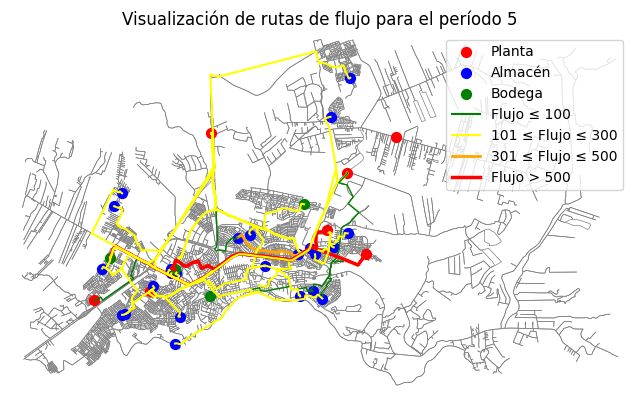

In [179]:
#Ejecutar función con grafo puerto montt y periodo i
visualizar_flujo_periodo(PM, 5)

#### funcion 2

Construir una función que reciba como argumentos una bodega, y que entregue la 
evolución de su nivel de inventario. Esta función también debe permitir hacer este 
análisis en forma agregada para el sistema (es decir, sumado para todas las bodegas)

In [147]:
def preprosecesamiento_para_bodegas(solucion: dict, tipo: str):
    # creo una matriz con ceros para actualizarla segun el inventario
    I=0
    if tipo == 'B':
        I = parametros.B
        pred = 'B_aux'
        tipos_nodo = nodos_bodegas
        inv = inventario_inicial_adicional['1']

    elif tipo == 'P':
        I = parametros.P
        pred = 'P_aux'
        tipos_nodo = nodos_produccion
        inv = inventario_inicial['1']
    
    else:
        print('Los tipos de bodega son:\nB -> bodega adicional\nP->bodega fábrica')
        return
    
    J = parametros.T + 1

    # PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
    columnas = list(list(range(1,parametros.T + 1)))
    filas = []
    for a in range(1,I):
        columnas.append(a)
        filas.append(np.float64(0))
    filas.append(np.float64(0))

    dict_matriz = dict()
    for b in range(0,J-1):
        dict_matriz[columnas[b]] = filas

    ppp = pd.DataFrame(data = dict_matriz)
    ppp['id'] = list(tipos_nodo.index)

    ppp = ppp.set_index('id')

    # al dia 1 le pongo el inventario inicial
    ppp[1] = inv


    for a in range(1, 9):
        num_dia = a
        if num_dia == 8:
            dia_actual = dias[num_dia-1]

        else:
            dia_actual = dias[num_dia-1]
            dia_siguiente = dias[num_dia]

        sol_1 = {}

    # saco de sol los nodos que no envian flujo, pongo los nodos que si envian algo en una nuevo diccionario

        for nodo_origen in list(solucion.keys()):
            if dia_actual in nodo_origen:
                if len(solucion[nodo_origen]) != 0:
                    sol_1[nodo_origen] = solucion[nodo_origen]
        sol_2 = {}
        for nodo_origen in list(sol_1.keys()):
            sol_2[nodo_origen] = {}
            for nodo_destino in sol_1[nodo_origen]:
                if sol_1[nodo_origen][nodo_destino] != 0:
                    sol_2[nodo_origen][nodo_destino] = sol_1[nodo_origen][nodo_destino]

        for nodo_origen in (list(sol_2.keys())):
            if pred in nodo_origen:
                for nodo_destino in (list(sol_2[nodo_origen].keys())):
                    if dia_siguiente in nodo_destino:
                        que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                        cantidad = sol_2[nodo_origen][nodo_destino]
                        ppp[num_dia+1][f'{tipo}{que_nodo_origen}'] = cantidad
                        
                        #print(f'Bodega {que_nodo_origen} guarda {cantidad} dulces para el día {num_dia+1}.')
    return ppp

In [148]:
def nivel_bodegas_fabricas(num_bodega: int, matriz_inventarios: pd.DataFrame):
    if num_bodega == 0:
        print('     Día    |       Inventario')
        print('___________________________________')
        for a in matriz_inventarios:
            print(f'''      {a}     |       {int(matriz_inventarios.sum()[a])} dulces''')
        return list(matriz_inventarios.sum())

    bodega = f'P{num_bodega}'
    if bodega not in list(matriz_inventarios.index):
        print('No existe ese número de bodega')
    
    else:
        print('     Día    |       Inventario')
        print('___________________________________')
        for a in matriz_inventarios:
            print(f'''      {a}     |       {int(matriz_inventarios.loc[bodega][a])} dulces''')
        return list(matriz_inventarios.loc[bodega])


In [149]:
def nivel_bodegas_extra(num_bodega: int, matriz_inventarios: pd.DataFrame):
    if num_bodega == 0:
        print('     Día    |       Inventario')
        print('___________________________________')
        for a in matriz_inventarios:
            print(f'''      {a}     |       {int(matriz_inventarios.sum()[a])} dulces''')
        return list(matriz_inventarios.sum())

    bodega = f'B{num_bodega}'
    if bodega not in list(matriz_inventarios.index):
        print('No existe ese número de bodega')
    
    else:
        print('     Día    |       Inventario')
        print('___________________________________')
        for a in matriz_inventarios:
            print(f'''      {a}     |       {int(matriz_inventarios.loc[bodega][a])} dulces''')
        return list(matriz_inventarios.loc[bodega])


In [150]:
# EJECUTAR ESTA CELDA PARA REVISAR UNA BODEGA ADICIONAL
num_bodega = 6      # elegir aqui que numero de bodega revisar, si se quieren todas las de un tipo, poner 0

matriz_inv = preprosecesamiento_para_bodegas(sol, 'P') # P es si quiero de las bodegas de las fabricas,
                                                       # B si quiero de las bodegas adicionales
nivel_bodegas_fabricas(num_bodega, matriz_inv)

     Día    |       Inventario
___________________________________
      1     |       304 dulces
      2     |       1949 dulces
      3     |       156 dulces
      4     |       2513 dulces
      5     |       0 dulces
      6     |       3208 dulces
      7     |       1124 dulces
      8     |       676 dulces


[304.0, 1949.0, 156.0, 2513.0, 0.0, 3208.0, 1124.0, 676.0]

#### funcion 3

Construir  una  función  que  construya  un  reporte  de  operación  diaria,  que  indique 
claramente el plan operativo del día, en un formato que podría ser fácilmente entendido 
por el personal responsable de ejecutar las instrucciones.

In [185]:
def imprimir_programacion(num_dia: int):
    if num_dia > 8:
        print('Día fuera del periodo productivo.')

    elif num_dia == 8:
        dia_actual = dias[num_dia-1]
        día_siguiente = dia_actual

    else:
        dia_actual = dias[num_dia-1]
        dia_siguiente = dias[num_dia]

    sol_1 = {}

    # saco de sol los nodos que no envian flujo, pongo los nodos que si envian algo en una nuevo diccionario

    for nodo_origen in list(sol.keys()):
        if dia_actual in nodo_origen:
            if len(sol[nodo_origen]) != 0:
                sol_1[nodo_origen] = sol[nodo_origen]

    sol_2 = {}
    for nodo_origen in list(sol_1.keys()):
        sol_2[nodo_origen] = {}
        for nodo_destino in sol_1[nodo_origen]:
            if sol_1[nodo_origen][nodo_destino] != 0:
                sol_2[nodo_origen][nodo_destino] = sol_1[nodo_origen][nodo_destino]

    # imprimo el tipo de nodo de origen desde el que envio

    for nodo_origen in (list(sol_2.keys())):
        if 'P_aux' not in nodo_origen and 'P_bod' not in nodo_origen and 'P' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if 'P_aux' in nodo_destino:
                    que_nodo = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo} produce {cantidad} dulces.')

        if 'P_bodega' in nodo_origen:        
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                cantidad = sol_2[nodo_origen][nodo_destino]
                if 'D' in nodo_destino:
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces al almacén {que_nodo_destino}.')
                
                if 'B' in nodo_destino:
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces a la bodega {que_nodo_destino}.')
        
        if 'P_aux' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):            
                if dia_siguiente in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]
                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo_origen} guarda {cantidad} dulces para el dia siguiente.')
        
        if 'B' in nodo_origen and 'B_aux' not in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if 'D' in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Bodega {que_nodo_origen} envia {cantidad} dulces al almacen {que_nodo_destino}.')
        
        if 'B_aux' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if dia_siguiente in nodo_destino:
                    que_nodo_origen = funciones.extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino = funciones.extraer_numeros(nodo_destino.split(',')[0])[0]

                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Bodega {que_nodo_origen} guarda {cantidad} dulces para el día siguiente.')

In [186]:
for t in range(1, parametros.T + 1):
    print(f'\nDÍA {t}')
    imprimir_programacion(t)


DÍA 1
Fábrica 1 produce 1139 dulces.
Fábrica 2 produce 36 dulces.
Fábrica 3 produce 1200 dulces.
Fábrica 4 produce 738 dulces.
Fábrica 5 produce 1962 dulces.
Fábrica 6 produce 1949 dulces.
Fábrica 7 produce 833 dulces.
Fábrica 1 envia 36 dulces al almacén 15.
Fábrica 1 envia 162 dulces al almacén 16.
Fábrica 1 envia 201 dulces al almacén 17.
Fábrica 1 envia 102 dulces al almacén 19.
Fábrica 2 envia 5 dulces al almacén 15.
Fábrica 2 envia 300 dulces al almacén 24.
Fábrica 3 envia 198 dulces al almacén 19.
Fábrica 3 envia 301 dulces al almacén 22.
Fábrica 4 envia 51 dulces al almacén 15.
Fábrica 5 envia 43 dulces al almacén 12.
Fábrica 5 envia 145 dulces al almacén 14.
Fábrica 5 envia 11 dulces al almacén 15.
Fábrica 5 envia 301 dulces al almacén 18.
Fábrica 6 envia 103 dulces al almacén 15.
Fábrica 6 envia 201 dulces al almacén 20.
Fábrica 7 envia 200 dulces al almacén 13.
Fábrica 7 envia 101 dulces al almacén 14.
Bodega 1 envia 100 dulces al almacen 16.
Bodega 2 envia 20 dulces al alm

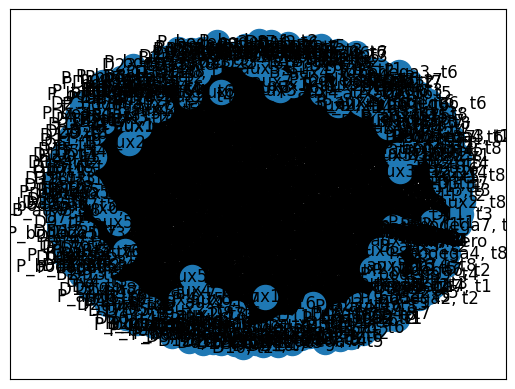

In [153]:
nx.draw_networkx(G1)

# Parte II: Análisis

### Costos

Desglose de costos totales por transporte, bodegaje, producción y demanda no 
satisfecha.

In [187]:
# costos por transporte hacia las tiendas y bodega
costo_neto_fabricas_demandas = 0
costo_neto_bodegas_demandas = 0
costo_neto_fabricas_bodegas = 0
ganancia = 0

# P -> D
for nodo_origen in sol:
    if 'P_bodega' in nodo_origen:
        numero_nodo_origen = funciones.extraer_numeros(nodo_origen.split(', ')[0])[0]
        
        info_envio = sol[nodo_origen]
        nodos_destino = list(info_envio.keys())
        
        for nodo_destino in nodos_destino:
            if 'D' in nodo_destino:
                nombre_nodo_destino = nodo_destino.split(', ')[0]
                periodo = funciones.extraer_numeros(nodo_destino.split(', ')[1])[0]
                cantidad = info_envio[nodo_destino]

                costo_envio_unidad = prod_demanda.loc[f'P{numero_nodo_origen}'][nombre_nodo_destino]

                costo_neto_fabricas_demandas += cantidad * costo_envio_unidad
                ganancia += cantidad * precio_venta.loc[f'D{periodo}'][f'{periodo}']

# B -> D
    if 'B' in nodo_origen:
        info_envio = sol[nodo_origen]
        nombre_nodo_origen = nodo_origen.split(', ')[0]
        nodos_destino = list(info_envio.keys())
        
        for nodo_destino in nodos_destino:
            if 'D' in nodo_destino:
                nombre_nodo_destino = nodo_destino.split(', ')[0]
                periodo = funciones.extraer_numeros(nodo_destino.split(', ')[1])[0]
                cantidad = info_envio[nodo_destino]

                costo_envio_unidad = bod_demanda.loc[nombre_nodo_origen][nombre_nodo_destino]
                
                costo_neto_bodegas_demandas += cantidad * costo_envio_unidad
                ganancia += cantidad * precio_venta.loc[f'D{periodo}'][f'{periodo}']

# P -> B
    if 'P_bodega' in nodo_origen:
        
        numero_nodo_origen = funciones.extraer_numeros(nodo_origen.split(', ')[0])[0]
        
        info_envio = sol[nodo_origen]
        nodos_destino = list(info_envio.keys())
        
        for nodo_destino in nodos_destino:
            
            if 'B_aux' in nodo_destino:
                numero_nodo_destino = funciones.extraer_numeros(nodo_destino.split(', ')[0])[0]
                periodo = funciones.extraer_numeros(nodo_destino.split(', ')[1])[0]

                cantidad = info_envio[nodo_destino]
                costo_envio_unidad = prod_bodega.loc[f'P{numero_nodo_origen}'][f'B{numero_nodo_destino}']
                if cantidad!=0:
                    costo_neto_fabricas_bodegas += cantidad * costo_envio_unidad

In [188]:
# costo produccion
costo_produccion = 0

# p -> p_aux
for t in range(1, parametros.T):
    for p in range(1, parametros.P + 1):
        nodo_origen = f'P{p}, t{t}'
        nodo_destino = f'P_aux{p}, t{t}'
        
        if sol[nodo_origen] != 0:
            costo_produccion += G1.get_edge_data(nodo_origen, nodo_destino)['weight']

In [156]:
# costos por bodegaje:
costo_neto_bodegaje_en_fabricas = 0
costo_neto_bodegaje_en_bodegas_ad = 0

# p_aux, t -> p_bod, t+1
for t in range(1, parametros.T):
    for p in range(1, parametros.P + 1):
        nodo_origen = f'P_aux{p}, t{t}'
        nodo_destino = f'P_bodega{p}, t{t+1}'

        if sol[nodo_origen] != 0:
            costo_neto_bodegaje_en_fabricas += G1.get_edge_data(nodo_origen, nodo_destino)['weight']

# b_aux, t -> b, t+1
for t in range(1, parametros.T):
    for b in range(1, 5):
        nodo_origen = f'B_aux{b}, t{t}'
        nodo_destino = f'B{b}, t{t+1}'

        if sol[nodo_origen] != 0:
            costo_neto_bodegaje_en_bodegas_ad += G1.get_edge_data(nodo_origen, nodo_destino)['weight']

In [157]:
# me dice la demanda q el sumidero esta supliendo, es decir demanda no satisfecha
for a in sol['Sumidero'].keys():
    if sol['Sumidero'][a] !=0:
        print(a+':',sol['Sumidero'][a])

# costos totales totales
nx.cost_of_flow(G1, sol)

D1, t1: 204
D2, t1: 400
D3, t1: 300
D4, t1: 304
D5, t1: 205
D6, t1: 400
D7, t1: 300
D8, t1: 304
D9, t1: 204
D10, t1: 305
D11, t1: 304
D12, t1: 157
D21, t1: 201
D23, t1: 200


2.7142e+23